In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score

import pandas as pd
import numpy as np
import torch
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
boston = load_boston()

In [3]:
data_frame = pd.DataFrame(boston.data)
data_frame.columns = boston.feature_names
data_frame['MEDV'] = boston.target

In [4]:
# check for dirty data

percent_of_empty_data = data_frame.replace(0, np.nan, inplace=True)
print("Amount of data cells with '0' replaced by NaN: " + str(percent_of_empty_data))

percent_of_nan_data = data_frame.isnull().sum() / len(data_frame)
print("Percent of NaN data cells: \n" + str(percent_of_nan_data))

Amount of data cells with '0' replaced by NaN: None
Percent of NaN data cells: 
CRIM       0.000000
ZN         0.735178
INDUS      0.000000
CHAS       0.930830
NOX        0.000000
RM         0.000000
AGE        0.000000
DIS        0.000000
RAD        0.000000
TAX        0.000000
PTRATIO    0.000000
B          0.000000
LSTAT      0.000000
MEDV       0.000000
dtype: float64


In [5]:
# clean dirty data
data_frame = data_frame.drop("ZN", axis=1)
data_frame = data_frame.drop("CHAS", axis=1)

(array([ 21.,  55.,  82., 154.,  84.,  41.,  30.,   8.,  10.,  21.]),
 array([ 5. ,  9.5, 14. , 18.5, 23. , 27.5, 32. , 36.5, 41. , 45.5, 50. ]),
 <a list of 10 Patch objects>)

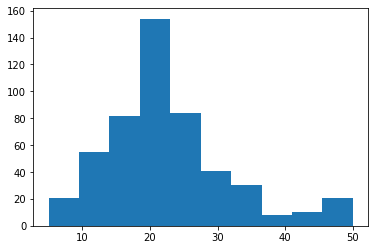

In [6]:
# check for dataset normal distribution constrain

plt.hist(data_frame['MEDV'])

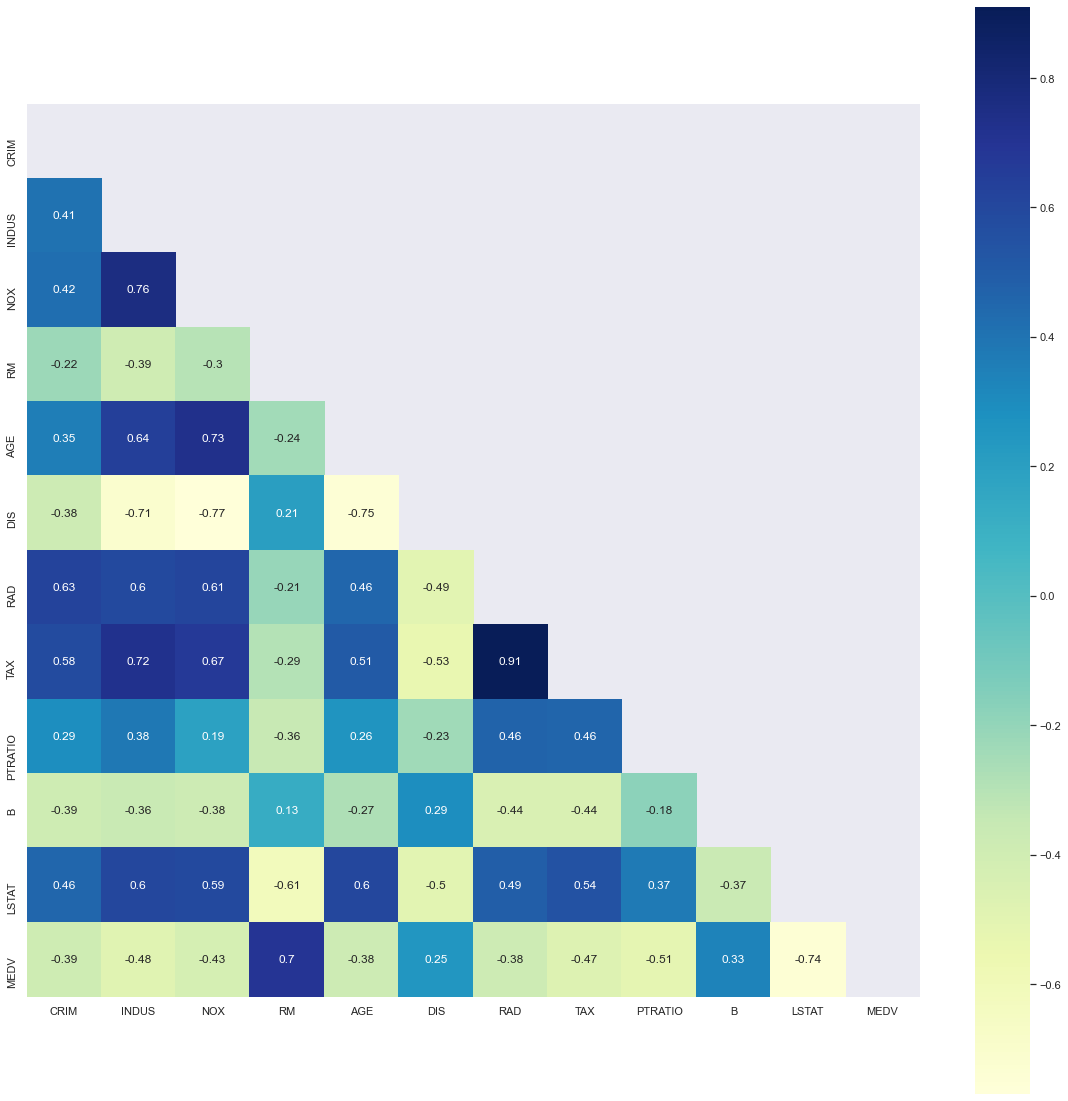

In [7]:
# look for correlated data, avoid multi correlated data (features that depends on each other) within regression feature

corr = data_frame.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.set(rc={'figure.figsize': (20, 20)})
sns.heatmap(corr, mask=mask, square=True, cmap='YlGnBu', annot=True)

In [8]:
# our choice
# medv:rm (+) medv:lstat(-) 

# drop columns
# [tax:rad (+), tax:indus(+) dis:indus(-) dis:age(-) dis:noz(-) age:nox(+) nox:indus(+)]

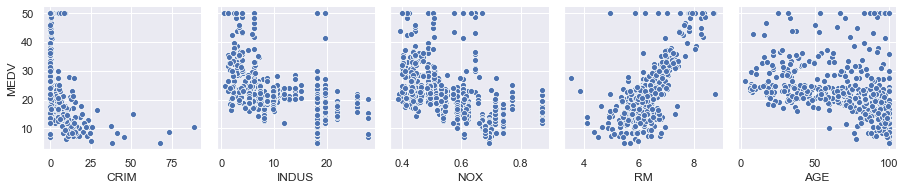

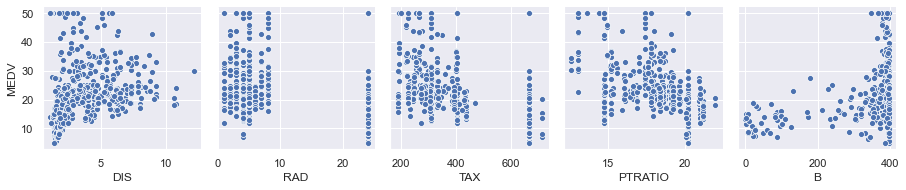

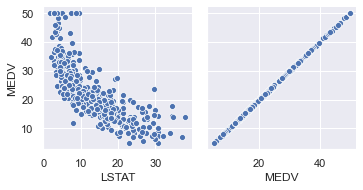

In [9]:
# just to visually confirm selected columns  
for i in range(0, len(data_frame.columns), 5):
    sns.pairplot(data=data_frame,
                x_vars=data_frame.columns[i:i+5],
                y_vars=['MEDV'])

In [10]:
# to see the difference between raw and normalized input data try raw dataset first
data_frame['LOGLSTAT'] = data_frame['LSTAT'].apply(np.log)
data_frame['LOGCRIM'] = data_frame['CRIM'].apply(np.log)
data_frame['LOGDIS'] = data_frame['DIS'].apply(np.log)
data_frame['LOGTAX'] = data_frame['TAX'].apply(np.log)

In [11]:
X = data_frame[["LOGCRIM", "LOGDIS", "LOGTAX", "LOGLSTAT", "RM"]].to_numpy()

X = (X - X.mean()) / X.std()
X = np.c_[np.ones(X.shape[0]), X] 

y = data_frame["MEDV"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [12]:
from sklearn.preprocessing import RobustScaler

scaler= RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [13]:
# test with sklearn regressor
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
test_model = regressor.fit(X_train, y_train)
y_predict = test_model.predict(X_train)

r2 = r2_score(y_train, y_predict)

print(f'R2 score={r2}, on validation dataset={regressor.score(X_test, y_test)}')

R2 score=0.7489148743258148, on validation dataset=0.6094003108243633


In [14]:
# verify r2 score on the model
def verify_score(model, X_test, y_test):
    
    model.eval()

    if torch.is_tensor(X_test) != True:
        X_test = torch.from_numpy(X_test).clone()
        y_test = torch.from_numpy(y_test).clone().reshape(-1,1)

    y_pred = model(X_test)
    # y_pred = y_pred.reshape(-1,-1)

    y_train_np = np.around(y_test, decimals=1).numpy()
    predicts_np = np.around(y_pred.clone().detach(), decimals=1).numpy()

    r2 = r2_score(y_train_np, predicts_np)

    print(f'r2 score = {r2}')
    
    return r2

In [15]:
# convert to the required shape 
X_train = torch.from_numpy(X_train).clone()
y_train = torch.from_numpy(y_train).clone().reshape(-1,1)

In [16]:
# architect the model
input_w_num = X_train.shape[1]
output_w_num = input_w_num * 3
model = torch.nn.Sequential(
    torch.nn.Linear(input_w_num, output_w_num, bias=True), torch.nn.ELU(),
    torch.nn.Linear(output_w_num, output_w_num, bias=True), torch.nn.ELU(),
    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(output_w_num, input_w_num, bias = True), torch.nn.Sigmoid(),
    torch.nn.Linear(input_w_num, 1)
)

model.load_state_dict(torch.load('model_state.txt'))
model.eval()

Sequential(
  (0): Linear(in_features=6, out_features=18, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=18, out_features=18, bias=True)
  (3): ELU(alpha=1.0)
  (4): Dropout(p=0.2, inplace=False)
  (5): Linear(in_features=18, out_features=6, bias=True)
  (6): Sigmoid()
  (7): Linear(in_features=6, out_features=1, bias=True)
)

In [17]:
model.double()
r2 = verify_score(model, X_test, y_test)
is_skip_training = r2 > 0.75

print("Skip training: " % is_skip_training)

intentionally stop chain execution

SyntaxError: invalid syntax (<ipython-input-17-2880256a2dc7>, line 7)

In [18]:
loss = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)

In [19]:
%%time
num_epoch = 16000
def train_model(model, loss, optimizer, x_train, y_train, num_epoch):
    train_accuracy_history = []
    train_avg_loss_history = []
    model.train()
    for n in range(num_epoch):
        correct_samples = 0
        total_samples = 0
        loss_accum = 0
        y_predicts = model(x_train)
        y_predicts = y_predicts.reshape(-1,1)
        loss_value = loss(y_train, y_predicts)
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        y_train_np = np.around(y_train, decimals=1).numpy()
        predicts_np = np.around(y_predicts.clone().detach(), decimals=1).numpy()
        
        correct_samples += np.sum(y_train_np == predicts_np)
        total_samples += y_train.shape[0]

        train_accuracy = float(correct_samples) / total_samples

        train_accuracy_history.append(train_accuracy)
        train_avg_loss_history.append(loss_value)
        
        r2 = r2_score(y_train_np, predicts_np)
        
        if n > 0 and (n % 100 == 0):
            print(f"Epoch={n}, train_avg_loss={loss_value}, train_accuracy={train_accuracy}. r2_score={r2}")

    return train_accuracy_history, train_avg_loss_history

Wall time: 0 ns


In [20]:
%%time
# train the model
model = model.double()
X_train = X_train.double()
y_train = y_train.double()
(train_accuracy_history, train_avg_loss_history) = train_model(model, loss, optimizer, X_train, y_train, num_epoch)

Epoch=100, train_avg_loss=10.350959683947023, train_accuracy=0.025423728813559324. r2_score=0.8669833739315987
Epoch=200, train_avg_loss=10.431541215042243, train_accuracy=0.022598870056497175. r2_score=0.8657850161225293
Epoch=300, train_avg_loss=9.852554150444838, train_accuracy=0.014124293785310734. r2_score=0.8730504239194448
Epoch=400, train_avg_loss=9.557373683895852, train_accuracy=0.011299435028248588. r2_score=0.876908001696819
Epoch=500, train_avg_loss=9.994307003327645, train_accuracy=0.025423728813559324. r2_score=0.8713699597830616
Epoch=600, train_avg_loss=9.956241750341919, train_accuracy=0.00847457627118644. r2_score=0.871937870856413
Epoch=700, train_avg_loss=9.469902631983377, train_accuracy=0.01694915254237288. r2_score=0.8781481711406102
Epoch=800, train_avg_loss=9.788498610203773, train_accuracy=0.00847457627118644. r2_score=0.874234602130652
Epoch=900, train_avg_loss=10.172454806808206, train_accuracy=0.00847457627118644. r2_score=0.8691510345073485
Epoch=1000, tr

Epoch=7600, train_avg_loss=8.733050836276027, train_accuracy=0.01694915254237288. r2_score=0.8875452451494714
Epoch=7700, train_avg_loss=8.78112102909216, train_accuracy=0.01694915254237288. r2_score=0.8868213584996362
Epoch=7800, train_avg_loss=8.671584101363543, train_accuracy=0.014124293785310734. r2_score=0.8884400141325174
Epoch=7900, train_avg_loss=8.877086352329528, train_accuracy=0.022598870056497175. r2_score=0.885864417433656
Epoch=8000, train_avg_loss=8.549561906550087, train_accuracy=0.011299435028248588. r2_score=0.8899059664038061
Epoch=8100, train_avg_loss=8.997505438234722, train_accuracy=0.01977401129943503. r2_score=0.8841548669426839
Epoch=8200, train_avg_loss=9.145343815990955, train_accuracy=0.00847457627118644. r2_score=0.8822438934461825
Epoch=8300, train_avg_loss=8.489820121616088, train_accuracy=0.02824858757062147. r2_score=0.890782556415234
Epoch=8400, train_avg_loss=9.05681142388539, train_accuracy=0.022598870056497175. r2_score=0.8833866236021002
Epoch=8500

Epoch=15000, train_avg_loss=8.246498501418795, train_accuracy=0.01694915254237288. r2_score=0.8938482581889211
Epoch=15100, train_avg_loss=8.054647978808823, train_accuracy=0.01694915254237288. r2_score=0.8963169625346677
Epoch=15200, train_avg_loss=8.375307452400005, train_accuracy=0.00847457627118644. r2_score=0.8921648854170792
Epoch=15300, train_avg_loss=8.569159469800809, train_accuracy=0.022598870056497175. r2_score=0.8897259945847863
Epoch=15400, train_avg_loss=8.515159028177084, train_accuracy=0.022598870056497175. r2_score=0.8902866340694905
Epoch=15500, train_avg_loss=8.493826918209932, train_accuracy=0.031073446327683617. r2_score=0.8907461984719977
Epoch=15600, train_avg_loss=8.635881851187836, train_accuracy=0.005649717514124294. r2_score=0.8889726580009296
Epoch=15700, train_avg_loss=8.711184415216906, train_accuracy=0.01694915254237288. r2_score=0.8878502882932242
Epoch=15800, train_avg_loss=8.425413542308133, train_accuracy=0.00847457627118644. r2_score=0.89156788798913

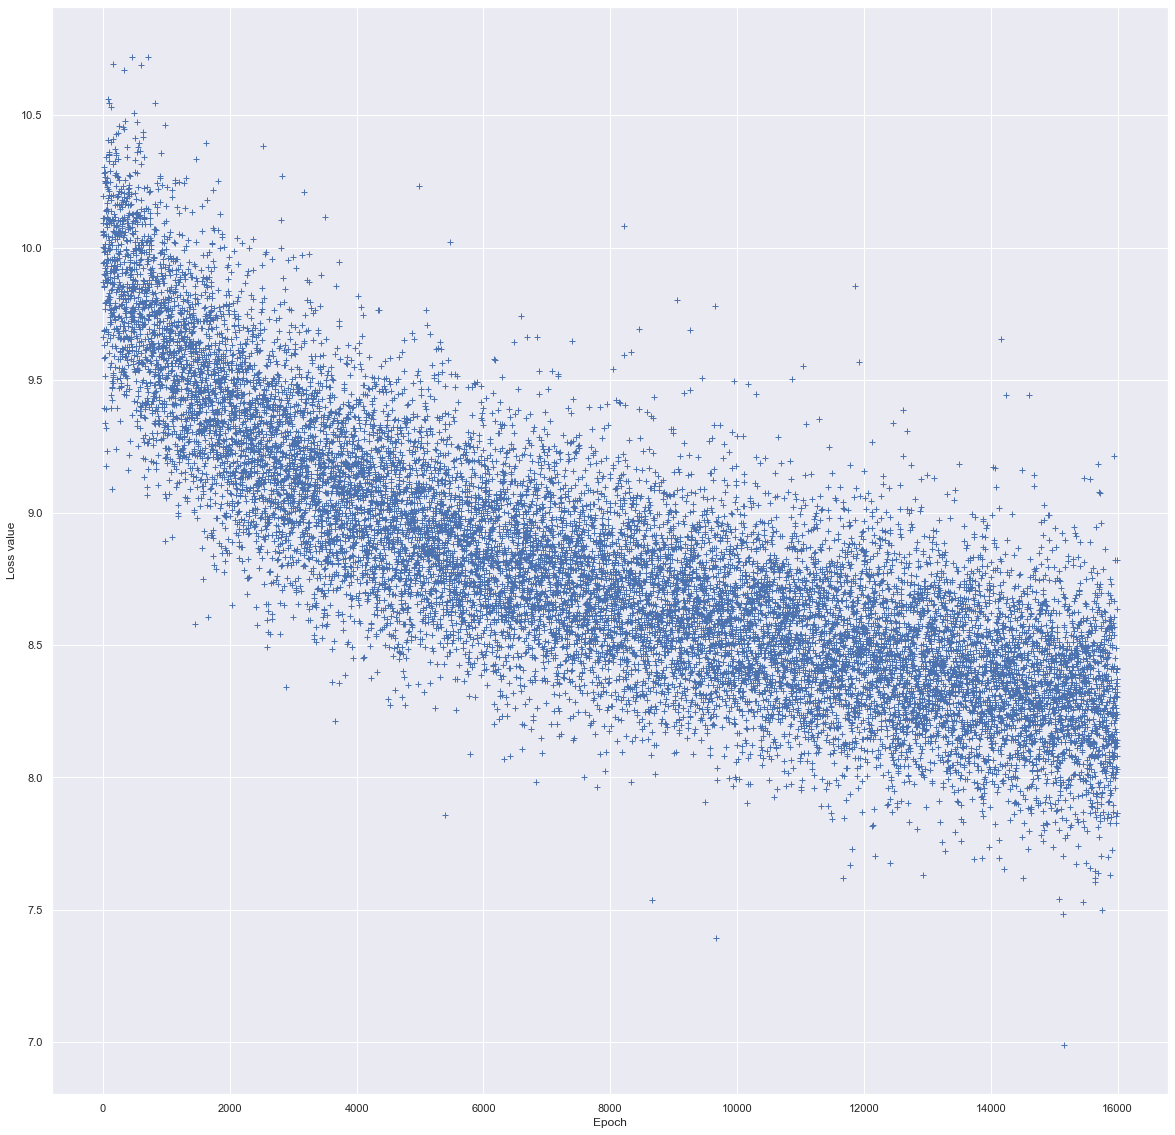

In [21]:
plt.plot(np.array(train_avg_loss_history), '+')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [22]:
# you converge the model, but with overfitting
# you want to include others valuable feature, but it would not work with Linear regression, at least as single layer


In [23]:
r2 = verify_score(model, X_test, y_test)

r2 score = 0.7378574974725185


In [ ]:
# torch.save(model.state_dict(), 'model_state.txt')